### This Jupyter notebook will be used to determine the user defines variables

#### Step 1 - Retrieve Location of Desired Study Area
Using either a shapefile, coordinate, or WKT the study area for where satalite imagery will be downloaded is to be determined

In [1]:
#import requirements
import pandas as pd
import geopandas as gpd
import asf_search as asf
from shapely import wkt

### Find data using a geographic search
To begin, we will need to craft a suitable WKT. ASF's [Vertex](https://search.asf.alaska.edu) can be helpful in this regard, as it allows you to draw on a map, or import a geospatial file such as a shapefile or geojson, after which a WKT string can be copied and used elsewhere. <br><br>
This method is good for bulk downloads of all scenes matching the description, excercise with caution as it will download the max limit (currently set at 10) and can take awhile.

In [6]:
#Select location using a WKT obtained from ASF's Vertex search site or copied from a geodatabase (must resemble: 'POLYGON((-85.5523 64.8284,-84.9823 64.8284,-84.9823 65.3214,-85.5523 65.3214,-85.5523 64.8284))')

location = input('input WKT string')
print('The given location is: ' + location)

The given location is: POLYGON((-85.5523 64.8284,-84.9823 64.8284,-84.9823 65.3214,-85.5523 65.3214,-85.5523 64.8284))


In [7]:
#input date range for search
dateStart = input('input start date in YYYY-MM-DD')
dateEnd = input('input end date in YYYY-MM-DD')

print('The date range of the search will be: ' + dateStart + ' to ' + dateEnd)

The date range of the search will be: 2020-01-01 to 2022-01-05


In [19]:
#perform the search for results with the given locations centroid and date range

centroidwkt = wkt.loads(location)
centroid = centroidwkt.centroid.wkt


centroid_results = asf.geo_search(
        intersectsWith=centroid,
        platform=asf.PLATFORM.SENTINEL1,
        maxResults=10,
        start=dateStart,
        end=dateEnd)

print(f'{len(centroid_results)} results found')

10 results found


In [18]:
#perform the search for results with the given location and date range, use if centroid yields no results

geo_results = asf.geo_search(
        intersectsWith=location,
        platform=asf.PLATFORM.SENTINEL1,
        maxResults=10,
        start=dateStart,
        end=dateEnd)

print(f'{len(geo_results)} results found')

10 results found


### Finding data using an existing scene name
If you already have the name of the scene (i.e. 'S1A_EW_GRDM_1SDH_20150205T122016_20150205T122116_004488_005812_F6B0') you can use this part of the program. This is the recommended method as it allows the user to visually verify the scene before downloading.

In [6]:
#create blank list OR run to reset current list
scene_list = []

In [8]:
#add scenes to the list to search using ASF's Vertex online app, run as many times as needed to append the list
#to follow the example please input 'S1B_IW_GRDH_1SDV_20200607T223317_20200607T223346_021933_0299FF_1064' & 'S1B_IW_GRDH_1SDV_20210614T223323_20210614T223352_027358_03447D_B0C9'
scene_list.append(input('input the scene here (i.e. \'S1B_IW_GRDH_1SDV_20200607T223317_20200607T223346_021933_0299FF_1064'))
print(scene_list)

['S1B_IW_GRDH_1SDV_20200607T223317_20200607T223346_021933_0299FF_1064', 'S1B_IW_GRDH_1SDV_20210614T223323_20210614T223352_027358_03447D_B0C9']


In [9]:
granule_results = asf.granule_search(scene_list)

print(f'{len(granule_results)} results found')

4 results found


#### Login to downlaod data

You to have an [Earthdata Login](https://urs.earthdata.nasa.gov/) account to access the download function. The easiest way to check that your EDL account is in order is to simply go to [Vertex](https://search.asf.alaska.edu) and try to download a product.

In [11]:
import getpass
from pathlib import Path

dirs = ['downloads']

In [12]:
#login to ASF using EE credentials
username = input('Username:')
password = getpass.getpass('Password:')


try:
    user_pass_session = asf.ASFSession().auth_with_creds(username, password)
except asf.ASFAuthenticationError as e:
    print(f'Auth failed: {e}')
else:
    print('Success!')

    #in the future i may add token and cookie login features

Success!


#### Download the data
The scene search will download the specific file the user found in [Vertex](https://search.asf.alaska.edu), this may be prefered to geographic search.<br><br>
The geographic search methods are good for bulk downloads of all scenes matching the description, excercise with caution as it will download the max limit (currently set at 10) and can take awhile.

In [13]:
import os.path
from os import mkdir

In [14]:
#set the downlaod directory, or create it if it doesnt exist
downPath = './downloads'
isDir = os.path.isdir(downPath)

if isDir == False:
    mkdir('downloads')

Downlaods can take awhile, with files capable of being mulitple GB each, please be patient

In [15]:
#download results from search
from os import listdir

#have user choose which result type to download
resultChoice=input('Type either: centroid, geo, or scene depending on the search criteria used')

if resultChoice == 'centroid':
    results = centroid_results
if resultChoice == 'geo':
    results = geo_results
if resultChoice == 'scene':
    results = granule_results
# else:
#     print('error, please try again')
    

results.download(path='./downloads', session=user_pass_session)

listdir('./downloads')



['S1B_IW_GRDH_1SDV_20200607T223317_20200607T223346_021933_0299FF_1064.iso.xml',
 'S1B_IW_GRDH_1SDV_20200607T223317_20200607T223346_021933_0299FF_1064.zip',
 'S1B_IW_GRDH_1SDV_20210614T223323_20210614T223352_027358_03447D_B0C9.iso.xml',
 'S1B_IW_GRDH_1SDV_20210614T223323_20210614T223352_027358_03447D_B0C9.zip']

### Data Manipulation
I have provided geotiffs in the data folder already to save the trouble of downloading and georeferencing. If self downloaded use following cell to ensure georeferencing is done to the same projection as shapefile

#### Unzip

In [22]:
#unzip downloaded products
import zipfile
from pathlib import Path

p = Path('.')

for f in p.glob('downloads/*.zip'):
    with zipfile.ZipFile(f, 'r') as archive:
        archive.extractall(path=f'./downloads/{f.stem}')
        print(f'Done {f.stem}')

Done S1B_IW_GRDH_1SDV_20200607T223317_20200607T223346_021933_0299FF_1064
Done S1B_IW_GRDH_1SDV_20210614T223323_20210614T223352_027358_03447D_B0C9


### Raster Manipulation

In [1]:
#clip raster images with polygon for study site
import fiona
import rasterio
import rasterio.mask
from rasterio import plot
from rasterio.plot import show

crs = rasterio.crs.CRS({"init": "epsg:4326"})

with fiona.open("data\location_polygon.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open('data\s1b-iw-grd-vv-20200607t223317-20200607t223346-021933-0299ff-001_gr.tiff') as src:
    #src.crs = crs #could not figure this one out... have to open the tif is QGIS and export it with the proper CRS
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("data/clipped.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [2]:
ds = rasterio.open('data/clipped.tif')
data = ds.read()

max = data.max()
mean = data.mean()

In [3]:
#reclassification
import numpy as np

lista = data.copy()

lista[np.where((lista >= 0) & (lista <= mean/2))] = 1 #deforested
lista[np.where((lista >= mean/2) & (lista <= mean))] = 2 #meh
lista[np.where((lista >= mean) & (lista <= max))] = 3 #forest

with rasterio.open('data/reclass.tif', 'w', 
driver=ds.driver,
height=ds.height,
width=ds.width,
count=ds.count,
transform=ds.transform,
dtype=data.dtype) as dst:
    dst.write(lista)

In [14]:
#resample
import rasterio
from rasterio.enums import Resampling

with rasterio.open('data/clipped.tif') as src:
    data = src.read(
        out_shape=(
            src.count,
            int(src.height * 1/2),
            int(src.width * 1/2)
        ),
        resampling=Resampling.bilinear)

# scale image transform
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )

AttributeError: module 'matplotlib.axes._subplots' has no attribute 'AxesSubplot'

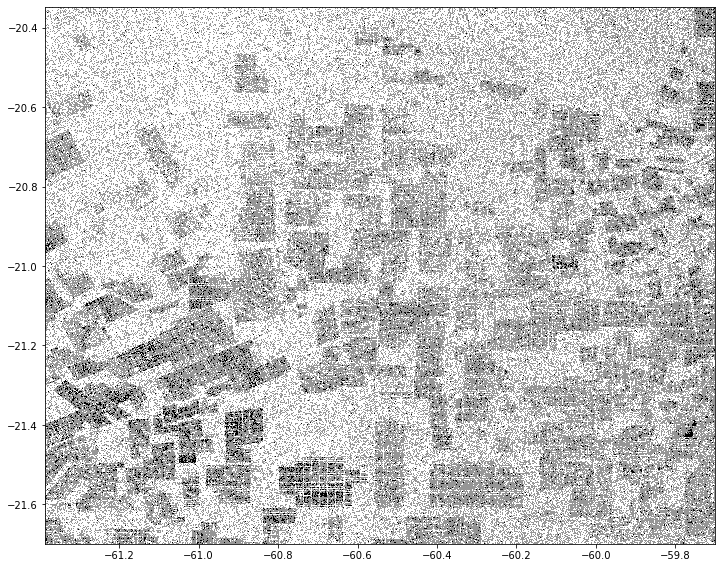

In [4]:
import matplotlib
from matplotlib import pyplot

src = rasterio.open("data/reclass.tif")
fig, ax = pyplot.subplots(1, figsize=(12, 12))
show((src, 1), cmap='Greys_r', interpolation='none', ax=ax)
matplotlib.axes._subplots.AxesSubplot
show((src, 1), contour=True, ax=ax)
matplotlib.axes._subplots.AxesSubplot
pyplot.show()

In [2]:
img2020=rasterio.open('data/clipped20200607.tif')
img2021=rasterio.open('data/clipped20210614.tif')
img=rasterio.open('data/clipped.tif')

### And now the files are ready for maipulation and analysis :D